In [46]:
# Installation silencieuse et optimisée des bibliothèques
!pip install --prefer-binary -r requirements.txt

In [47]:
# --- 1. IMPORTATION OUTILS  ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import BytesIO
from dotenv import load_dotenv
import boto3

# --- 2. OUTILS MACHINE LEARNING (Scikit-Learn) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# --- 3. CHARGEMENT DES ACCÈS ---
load_dotenv()

# --- 4. RÉCUPÉRATION DES DONNÉES DEPUIS LE DATA LAKE ---
def load_from_s3(file_name):
    # Connexion avec les id
    s3 = boto3.client(
        's3',
        aws_access_key_id=os.getenv('ACCESS_KEY'),
        aws_secret_access_key=os.getenv('SECRET_KEY'),
        region_name="eu-west-3"
    )
    
    # Lecture du flux de données
    bucket_name = os.getenv('BUCKET_NAME')
    obj = s3.get_object(Bucket=bucket_name, Key=file_name)
    
    # On ramène le fichier nettoyé dans un DataFrame
    data = pd.read_csv(BytesIO(obj['Body'].read()), sep=';')
    return data

# --- 5. INITIALISATION ---
df = load_from_s3("bank_marketing_cleaned_v1.csv")

print(f"✅ Données chargées avec succès depuis S3.")
print(f"📊 Dimensions du dataset : {df.shape}")
df.head()

✅ Données chargées avec succès depuis S3.
📊 Dimensions du dataset : (45211, 18)


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,pdays,previous,resultat_precedent,souscription,segment_contact,age_group
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,-1,0,no existant,no,Jamais contacte,Matures(46-63)
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,-1,0,no existant,no,Jamais contacte,Adultes(31-45)


## Preprocessing 

In [48]:
#1)  Supprimer les colonnes inutiles :

colonnes_inutiles = ['pdays','age_group']
df_clean = df.drop(columns =colonnes_inutiles)
df_clean.head()


,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,solde_bancaire,pret_immo,pret_conso,day,mois,duration,campaign,previous,resultat_precedent,souscription,segment_contact
0,58,management,married,tertiary,no,2143,yes,no,5,may,261,1,0,no existant,no,Jamais contacte
1,44,technician,single,secondary,no,29,yes,no,5,may,151,1,0,no existant,no,Jamais contacte
2,33,entrepreneur,married,secondary,no,2,yes,yes,5,may,76,1,0,no existant,no,Jamais contacte
3,47,blue-collar,married,unknown,no,1506,yes,no,5,may,92,1,0,no existant,no,Jamais contacte
4,33,unknown,single,unknown,no,1,no,no,5,may,198,1,0,no existant,no,Jamais contacte


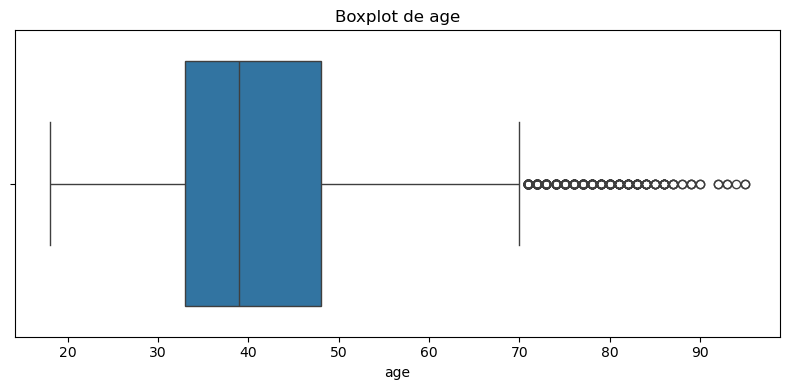

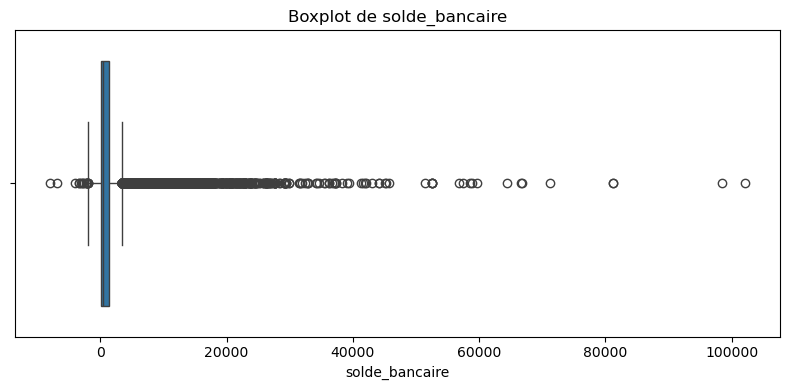

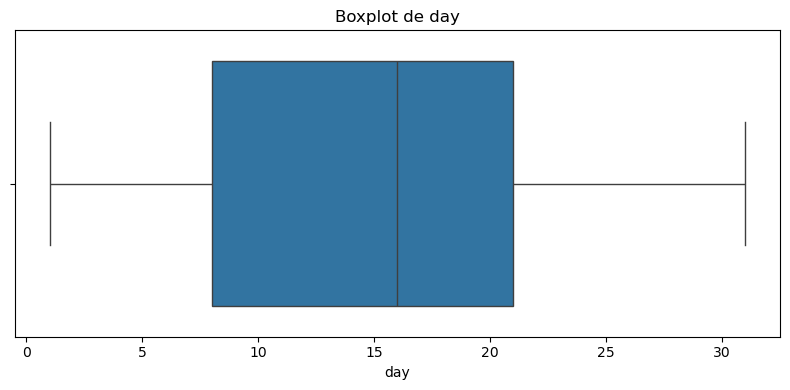

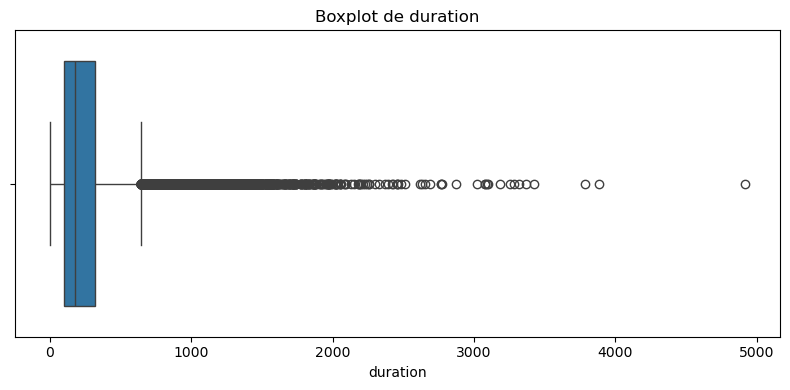

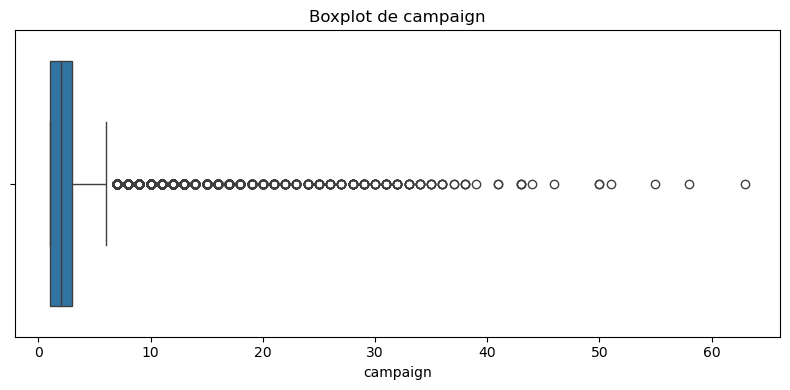

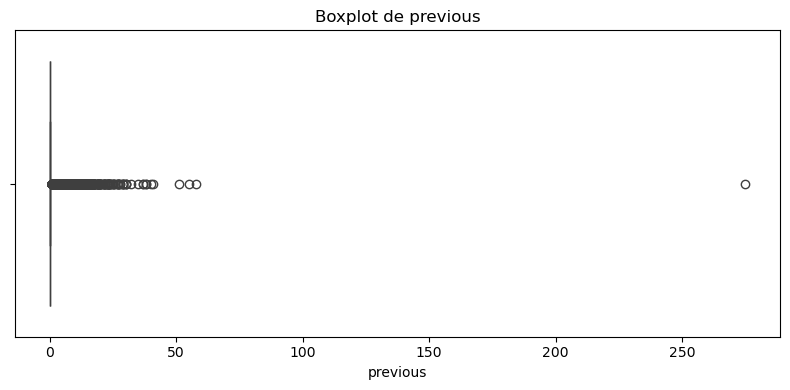

In [49]:
# 2) Déterminer si nous avons des valeurs abérrantes dans toutes les colonnes numeriques :

colonnes_numeriques = df_clean.select_dtypes(include=['int64', 'float64']).columns

# Créer un boxplot pour chaque colonne
for col in colonnes_numeriques:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_clean[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [51]:
df_clean["previous_log"] = np.log1p(df_clean["previous"])
df_clean["solde_bancaire_log"] = np.log1p(df_clean["solde_bancaire"])
df_clean["duration_log"] = np.log1p(df_clean["duration"])
df_clean["campaign_log"] = np.log1p(df_clean["campaign"])


c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\compte\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [59]:
colonnes_inutiles2 = ['duration','previous', 'campaign','solde_bancaire']
df_clean2 = df_clean.drop(columns =colonnes_inutiles2)
df_clean2.head()

,age,metier,statut_matrimonial,niveau_etudes,defaut_credit,pret_immo,pret_conso,day,mois,resultat_precedent,souscription,segment_contact,previous_log,solde_bancaire_log,duration_log,campaign_log
0,58,management,married,tertiary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.670429,5.568345,0.693147
1,44,technician,single,secondary,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,3.401197,5.023881,0.693147
2,33,entrepreneur,married,secondary,no,yes,yes,5,may,no existant,no,Jamais contacte,0.0,1.098612,4.343805,0.693147
3,47,blue-collar,married,unknown,no,yes,no,5,may,no existant,no,Jamais contacte,0.0,7.317876,4.532599,0.693147
4,33,unknown,single,unknown,no,no,no,5,may,no existant,no,Jamais contacte,0.0,0.693147,5.293305,0.693147


In [60]:
# 5) Séparer les variables explicatives x et la variable cible y : 
target_variable = 'souscription'
y = df_clean2.loc[: , target_variable]
x = df_clean2.drop(columns= target_variable)
print("x :")
print(x.head())
print()
print("y : ")
print(y.head())


x :
   age        metier statut_matrimonial niveau_etudes defaut_credit pret_immo  \
0   58    management            married      tertiary            no       yes   
1   44    technician             single     secondary            no       yes   
2   33  entrepreneur            married     secondary            no       yes   
3   47   blue-collar            married       unknown            no       yes   
4   33       unknown             single       unknown            no        no   

  pret_conso  day mois resultat_precedent  segment_contact  previous_log  \
0         no    5  may        no existant  Jamais contacte           0.0   
1         no    5  may        no existant  Jamais contacte           0.0   
2        yes    5  may        no existant  Jamais contacte           0.0   
3         no    5  may        no existant  Jamais contacte           0.0   
4         no    5  may        no existant  Jamais contacte           0.0   

   solde_bancaire_log  duration_log  campaign_log  


In [69]:
# 6) Détecter les noms des variables numeriques / catégorielles:

num_cols = x.select_dtypes(include=["int64","float64"]).columns
print(f'Found numeric features {list(num_cols)}')


cat_cols = x.select_dtypes(include=["object", "category"]).columns
print(f"Found categorical features {list(cat_cols)}")

Found numeric features ['age', 'day', 'previous_log', 'solde_bancaire_log', 'duration_log', 'campaign_log']
Found categorical features ['metier', 'statut_matrimonial', 'niveau_etudes', 'defaut_credit', 'pret_immo', 'pret_conso', 'mois', 'resultat_precedent', 'segment_contact']


In [70]:
# 7) Séparer les données pour créer un ensemble de données d'entrainement et un ensemble de données de test (20% de la data):
from sklearn.model_selection import train_test_split


x_train,x_test, y_train,y_test = train_test_split (x,y, test_size = 0.2, random_state=42)

In [75]:


#Remplacer infinities
x_train = x_train.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_train = x_train.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_train[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [76]:
# 8) Créer un pipeline pour les num_cols ainsi que les cat_cols  :

# A) il n'y aura pas d'imputation car nous n'avons pas de valeurs manquantes.
# B) standardisation pour les num_cols car on va utiliser une régression logistique,  
# C) Encodage des cat_cols :

from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder


numeric_transformer = Pipeline(steps=[ 
    ('scaler', StandardScaler())])
    
categorical_transformer = Pipeline(steps=[
   
    ('encoder', OneHotEncoder(drop='first')) ])

print('....Done.')

....Done.


In [77]:
# 9) création objet préprocesseur avec ColumnTransformer :

from sklearn.compose import ColumnTransformer


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols ),
        ('cat', categorical_transformer, cat_cols)
    ]
)
x_train = preprocessor.fit_transform(x_train)
print(x_train[0:5, :])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 58 stored elements and shape (5, 41)>
  Coords	Values
  (0, 0)	0.006514948449407755
  (0, 1)	-0.0982181693341559
  (0, 2)	-0.4251236883477022
  (0, 3)	0.5140233073973149
  (0, 4)	-0.9511690143172365
  (0, 5)	-0.9075872034676993
  (0, 6)	1.0
  (0, 17)	1.0
  (0, 23)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (1, 0)	0.7599367086994201
  (1, 1)	1.7034223914978113
  (1, 2)	-0.4251236883477022
  (1, 3)	0.6968747773169675
  (1, 4)	0.4678041927163298
  (1, 5)	-0.11630476694352175
  (1, 14)	1.0
  (1, 17)	1.0
  (1, 23)	1.0
  (1, 29)	1.0
  (1, 36)	1.0
  (1, 39)	1.0
  (2, 0)	0.1006926684806593
  :	:
  (2, 36)	1.0
  (2, 39)	1.0
  (3, 0)	-0.3701959316755984
  (3, 1)	-0.5786556522226806
  (3, 2)	-0.4251236883477022
  (3, 3)	-1.902679895802328
  (3, 4)	0.8270785261068283
  (3, 5)	2.5891077528288218
  (3, 9)	1.0
  (3, 18)	1.0
  (3, 20)	1.0
  (3, 23)	1.0
  (3, 30)	1.0
  (3, 36)	1.0
  (3, 39)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	-0.098

In [79]:
#Remplacer infinities
x_test = x_test.replace([np.inf, -np.inf], np.nan)

#Remplacer NaN
x_test = x_test.fillna(0)

#Vérifier variance nulle
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold() 
vt.fit(x_test[num_cols])
zero_var_cols = [c for c, v in zip(num_cols, vt.variances_) if v == 0]
print("Colonnes à variance nulle :", zero_var_cols)

Colonnes à variance nulle : []


In [80]:
x_test = preprocessor.transform(x_test)
print(x_test[0:5, : ])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 59 stored elements and shape (5, 41)>
  Coords	Values
  (0, 0)	-0.08766277158184378
  (0, 1)	0.021891201387975245
  (0, 2)	-0.4251236883477022
  (0, 3)	0.37770180540036075
  (0, 4)	0.10357786358901881
  (0, 5)	-0.9075872034676993
  (0, 6)	1.0
  (0, 17)	1.0
  (0, 19)	1.0
  (0, 23)	1.0
  (0, 32)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (1, 0)	0.571581268636917
  (1, 1)	-0.8188743936669428
  (1, 2)	-0.4251236883477022
  (1, 3)	1.0356386084021705
  (1, 4)	-0.7988991080614334
  (1, 5)	-0.11630476694352175
  (1, 12)	1.0
  (1, 18)	1.0
  (1, 19)	1.0
  (1, 30)	1.0
  (1, 36)	1.0
  (1, 39)	1.0
  :	:
  (2, 23)	1.0
  (2, 36)	1.0
  (2, 39)	1.0
  (3, 0)	0.1006926684806593
  (3, 1)	-0.8188743936669428
  (3, 2)	0.8750916544707351
  (3, 3)	0.77763207347363
  (3, 4)	0.6246564626576626
  (3, 5)	-0.9075872034676993
  (3, 9)	1.0
  (3, 17)	1.0
  (3, 20)	1.0
  (4, 0)	1.419180748918181
  (4, 1)	0.622438054998631
  (4, 2)	-0.4251236883477022
  (4, 3)	0.0264

## Baseline model (logistic regression)

In [81]:
# 1) Entrainement d'un modele de regression logistique et evaluation de ses performances :

from sklearn.linear_model import LogisticRegression


print('Train model ...')
model = LogisticRegression(max_iter=1000,class_weight='balanced') # class_weight est important pour les données déséquilibrée
model.fit(x_train,y_train)

print( '....Done.')

Train model ...
....Done.


In [82]:
# Prediction sur train : 
y_train_pred = model.predict(x_train)
print('....Done.')
print(y_train_pred[0:5])

....Done.
['no' 'no' 'no' 'no' 'yes']


In [83]:
# Prediction sur test : 
y_test_pred = model.predict(x_test)
print('....Done.')
print(y_test_pred[0:5])

....Done.
['no' 'no' 'yes' 'yes' 'no']


In [ ]:
# Evaluation des performances : 

# Print scores :

from sklearn.metrics import accuracy_score, f1_score


print("Accuracy on training set : ", accuracy_score(y_train, y_train_pred))
print("Accuracy on test set : ", accuracy_score(y_test, y_test_pred))


print(" F1_score on training set : ", f1_score(y_train, y_train_pred, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_test_pred, pos_label='yes'))

# Analyse des scores : 
# score Train f1 ≃ score Test f1 
# 

Accuracy on training set :  0.8202554744525548
Accuracy on test set :  0.8161008514873382
 F1_score on training set :  0.5208932124695999
 F1_score on test set :  0.5211632594298877


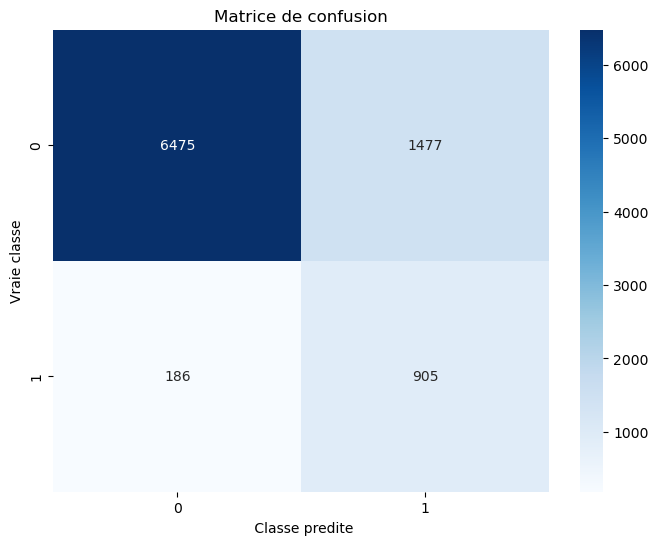

In [ ]:
# Vérifier la matrice de confusion :
from sklearn.metrics import confusion_matrix
cm = confusion_matrix (y_test, y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

# analyse de la matrice: 


Afin d'améliorer notre modele de base nous allons entrainer un autre modele Random forest ce dernier peut gérer ce trade-off

## Random Forest

In [86]:
# Modele Random Forest : 
from sklearn.ensemble import RandomForestClassifier


classifier = RandomForestClassifier( 
    n_estimators=100,
    max_depth=12,
    min_samples_split=50,
    min_samples_leaf=25,
    class_weight = 'balanced',
    random_state=42,
    max_features ='sqrt',
    n_jobs= -1)
classifier.fit(x_train, y_train)
print('...Done.')

...Done.


In [87]:
# Prediction  :
y_pred_train = classifier.predict(x_train)
print('y_pred_train....Done.')
print(y_pred_train[0:5])
y_pred_test = classifier.predict(x_test)
print('y_pred_test....Done.')
print(y_test_pred[0:5])

y_pred_train....Done.
['no' 'no' 'no' 'no' 'no']
y_pred_test....Done.
['no' 'no' 'yes' 'yes' 'no']


In [ ]:
# Evaluation des performances : 

# Print scores :

print("Accuracy on training set : ", accuracy_score(y_train, y_pred_train))
print("Accuracy on test set : ", accuracy_score(y_test, y_pred_test))


print(" F1_score on training set : ", f1_score(y_train, y_pred_train, pos_label='yes'))
print(" F1_score on test set : ", f1_score(y_test, y_pred_test, pos_label='yes'))

# Analyse des scores: 

Accuracy on training set :  0.8388630833886308
Accuracy on test set :  0.8302554462014818
 F1_score on training set :  0.5615407764068613
 F1_score on test set :  0.5470640306875184


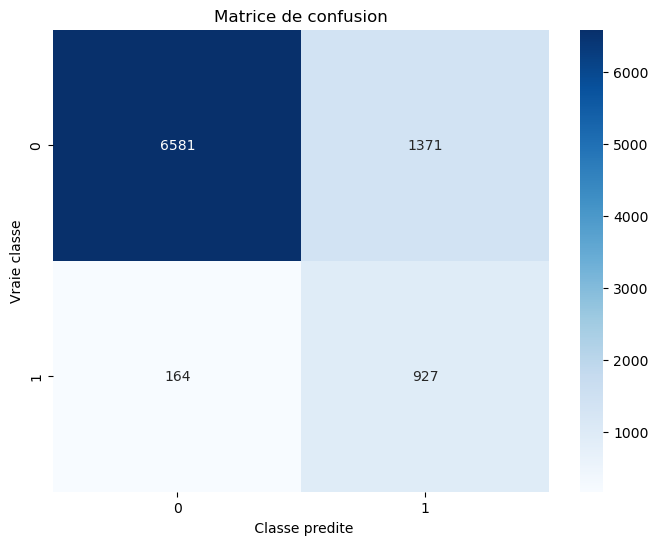

In [89]:
cm = confusion_matrix (y_test, y_pred_test)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='d',cmap ='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel(' Classe predite')
plt.show()

/!\ Conclusion  : 